In [1]:
import cira

cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

In [2]:
import pandas as pd 
import numpy as np
from typing import List, Dict

In [3]:
from datetime import datetime

assets_symbols = ["MSFT"]
stk_hist_data = {}
IS_CACHED = True

for SYMBOL in assets_symbols:
    SYM_HIST_FILE = f"./{SYMBOL}.csv"

    stk = cira.Stock(SYMBOL)

    if not IS_CACHED:
        start = datetime(2015, 7, 1)
        end = datetime(2023, 7, 1)
        stk.save_historical_data(SYM_HIST_FILE, start, end)
    
    data = stk.load_historical_data(SYM_HIST_FILE)
    stk_hist_data[SYMBOL] = data



<Axes: xlabel='timestamp'>

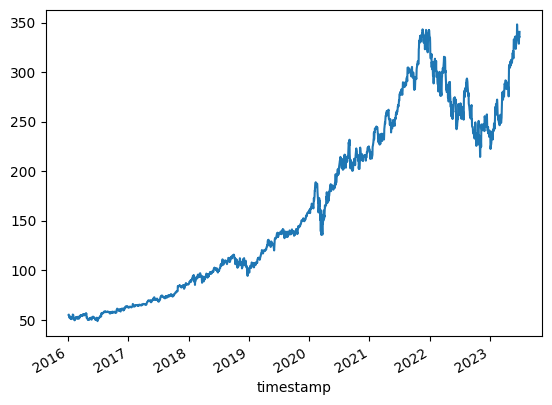

In [4]:
df = pd.DataFrame()
import matplotlib.pyplot as plt

#for sym, hist in stk_hist_data.items():
#    df[sym] = hist["close"]
#
#df["CASH"] = 1.0

df = data
df["close"].plot()

/tmp/ipykernel_7940/3413878880.py:1: RuntimeWarning: divide by zero encountered in log
  gradient = np.log(np.gradient(df['close'].values))
/tmp/ipykernel_7940/3413878880.py:1: RuntimeWarning: invalid value encountered in log
  gradient = np.log(np.gradient(df['close'].values))


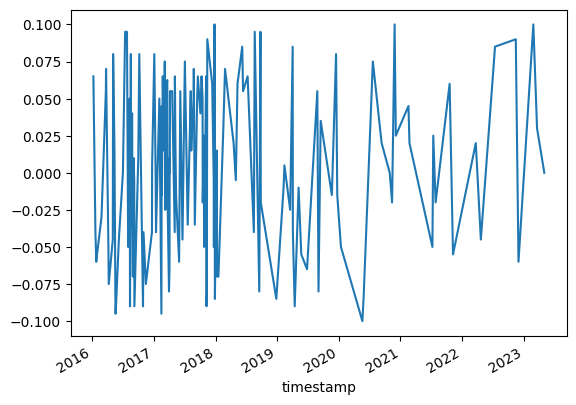

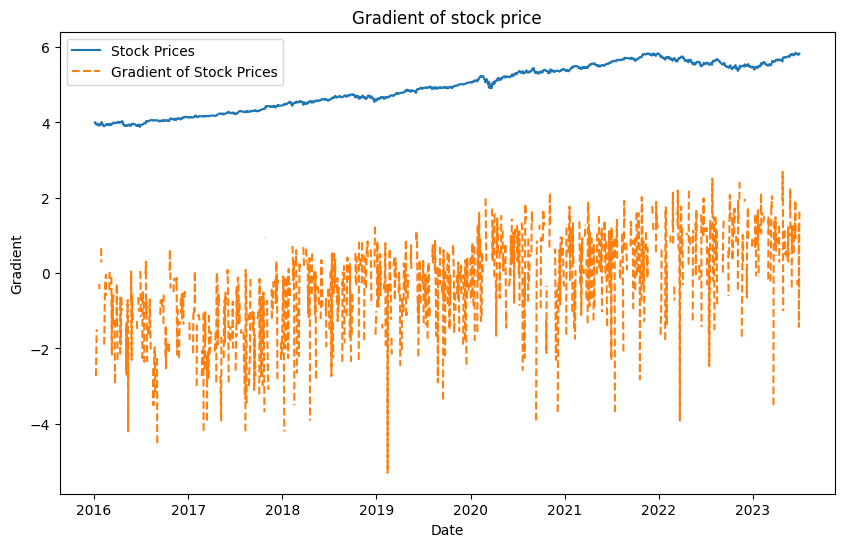

In [5]:

gradient = np.log(np.gradient(df['close'].values))
df["gradient"] = np.gradient(df['close'].values)
df[(df["gradient"] < 0.1) & (df["gradient"] > -0.1)]["gradient"].plot()
# Plot the stock prices and the gradient
plt.figure(figsize=(10, 6))
plt.plot(df.index, np.log(df['close']), label='Stock Prices')
plt.plot(df.index, gradient, label='Gradient of Stock Prices', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gradient')
plt.title('Gradient of stock price')
plt.legend()
plt.show()

In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize





In [7]:
split_prc = 0.7
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1886 1320 566


In [8]:
test_data.head()

,symbol,open,high,low,close,volume,trade_count,vwap,gradient
timestamp,,,,,,,,,
2021-04-01 04:00:00+00:00,MSFT,238.47,242.840,238.0501,242.35,32891747.0,369536.0,241.357539,6.650
2021-04-05 04:00:00+00:00,MSFT,242.76,249.960,242.7000,249.07,40227818.0,422760.0,248.243928,2.755
2021-04-06 04:00:00+00:00,MSFT,247.61,249.400,246.8800,247.86,25341057.0,271873.0,248.171074,0.415
2021-04-07 04:00:00+00:00,MSFT,247.81,250.930,247.1900,249.90,25128314.0,263870.0,249.750599,2.695
2021-04-08 04:00:00+00:00,MSFT,252.84,254.139,252.0000,253.25,26665389.0,280011.0,253.066578,2.975


In [9]:
from numpy import ndarray
from pandas import DataFrame
from cira.strategy.strategy import Strategy
from sklearn.linear_model import LinearRegression


class Linear(Strategy):
    def __init__(self) -> None:
        super().__init__(name="Linear")
        self.model = LinearRegression()
        self.features = ['open', 'high', 'low', 'volume', 'trade_count', 'vwap']
        self.target = "close"

        self.position_history = []


    def fit(self, train_data) -> None: 
        X_train = train_data[self.features]
        y_train = train_data[self.target]
        self.model.fit(X_train, y_train)

    def predict(self, feature_data: DataFrame, prices: DataFrame, cash: float) -> ndarray:
        y_pred = self.model.predict(feature_data[self.features]) 
        